In [ ]:
!pip install tensorflow_decision_forests -U -qq
!pip install wurlitzer -U -qq

In [126]:
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [127]:
model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)

data = pd.read_csv("/content/result.csv", delimiter=';', encoding='utf-8')

train_df, test_df = train_test_split(data, test_size=0.3, random_state=24)

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="N_Fe", task=model.task)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label="N_Fe", task=model.task)

Use /tmp/tmpfdlz67f3 as temporary training directory


In [96]:
#@title Define "set_cell_height".

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

In [128]:
tuner = tfdf.tuner.RandomSearch(num_trials=50)

tuner.choice("num_trees", [100, 150, 200, 250])
tuner.choice("max_depth", [10, 15, 20])
tuner.choice("min_examples", [5, 10, 15]) # Мін. кількість прикладів для створення нового вузла в дереві
tuner.choice("num_candidate_attributes_ratio", [1.0, 0.8, 0.6]) # частка атрибутів, яка буде розглянута під час кожного розбиття

**min_examples**

Коли дерево рішень будується в процесі навчання, воно ухвалює рішення про розбиття вузла на два підвузли на основі значень якоїсь ознаки. Однак розбиття відбувається тільки в тому випадку, якщо кількість прикладів у вузлі більша, ніж min_examples. Збільшення цього значення може призвести до більш стійкого дерева, але з більш грубими розбиттями.

**num_candidate_attributes_ratio**

Якщо значення дорівнює 1.0, то розглядаються всі атрибути. Якщо значення дорівнює 0.8, то розглядається 80% атрибутів, обраних випадковим чином. Це запобігає перенавчанню, оскільки випадковий ліс не буде надто чутливим до конкретних ознак і буде узагальнюватися краще на нові дані.



In [129]:
%%time
%set_cell_height 300

tuned_model = tfdf.keras.RandomForestModel(tuner=tuner, task=tfdf.keras.Task.REGRESSION)
tuned_model.fit(train_ds, verbose=2)

<IPython.core.display.Javascript object>

Use /tmp/tmpjn1c6kin as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'N_B': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'T': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'd': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'Jsc_e': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Eta_e': <tf.Tensor 'data_4:0' shape=(None,) dtype=float64>, 'Voc_e': <tf.Tensor 'data_5:0' shape=(None,) dtype=float64>}
Label: Tensor("data_6:0", shape=(None,), dtype=float64)
Weights: None
Normalized tensor features:
 {'N_B': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'T': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'd': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_2:0' shape=(None,) dtype=float32>), 'Jsc_e': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_3:0' s

[INFO 23-11-17 00:31:57.8716 UTC kernel.cc:771] Start Yggdrasil model training
[INFO 23-11-17 00:31:57.8716 UTC kernel.cc:772] Collect training examples
[INFO 23-11-17 00:31:57.8716 UTC kernel.cc:785] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-11-17 00:31:57.8718 UTC kernel.cc:391] Number of batches: 9
[INFO 23-11-17 00:31:57.8718 UTC kernel.cc:392] Number of examples: 8662
[INFO 23-11-17 00:31:57.8725 UTC kernel.cc:792] Training dataset:
Number of records: 8662
Number of columns: 7

Number of columns by type:
	NUMERICAL: 7 (100%)

Columns:

NUMERICAL: 7 (100%)
	0: "Eta_e" NUMERICAL mean:-4.68073 min:-50.1 max:10.1 sd:9.16897
	1: "Jsc_e" NUMERICAL mean:-3.37099 min:-40.7 max:6.25 sd:7.24083
	2: "N_B" NUMERICAL mean:15.9975 m

Model trained in 0:03:57.336266
Compiling model...
Model compiled.
CPU times: user 5min 44s, sys: 3.17 s, total: 5min 48s
Wall time: 3min 57s


In [130]:
# x - вхідні дані, y - цільові дані
# Створює список масивів, по одному для кожної істинної мітки в наборі тестових даних
true_labels = np.concatenate([y.numpy() for x, y in test_ds])
predicted_values = tuned_model.predict(test_ds).flatten()
result_df = pd.DataFrame({"True_Labels": true_labels, "Predicted_Values": predicted_values})
print(result_df)

4/4 [==============================] - 0s 21ms/step
      True_Labels  Predicted_Values
0       11.499687         11.526778
1       11.167317         11.198588
2       14.000000         13.918464
3       10.666518         10.667681
4       13.833147         13.833383
...           ...               ...
3708    13.833147         13.841842
3709    11.000000         10.994616
3710    11.499687         11.483504
3711    10.666518         10.652451
3712    13.000000         12.982867

[3713 rows x 2 columns]


In [131]:
result_df[['True_Labels', 'Predicted_Values']].to_csv('predicted_vs_true.csv', sep=';', index=False)

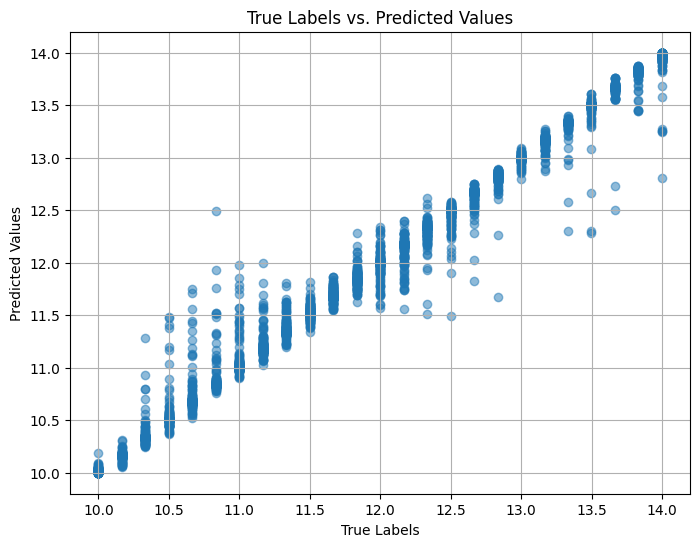

In [132]:
plt.figure(figsize=(8, 6))
plt.scatter(result_df["True_Labels"], result_df["Predicted_Values"], alpha=0.5)
plt.title("True Labels vs. Predicted Values")
plt.xlabel("True Labels")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

In [133]:
# Display the tuning logs.
tuning_logs = tuned_model.make_inspector().tuning_logs()
sorted_logs = tuning_logs.sort_values(by='score', ascending=False)
top_models = sorted_logs.head(5)
display(top_models)

,score,evaluation_time,best,num_trees,max_depth,min_examples,num_candidate_attributes_ratio
26,-0.130338,125.186031,True,150,20,5,0.6
6,-0.131170,31.615007,False,250,15,5,0.6
29,-0.131414,137.390157,False,100,15,5,0.6
1,-0.131941,8.476200,False,150,15,5,0.6
31,-0.136476,150.536088,False,150,20,5,1.0


In [134]:
# Best hyper-parameters.
tuning_logs[tuning_logs.best].iloc[0]

score                              -0.130338
evaluation_time                   125.186031
best                                    True
num_trees                                150
max_depth                                 20
min_examples                               5
num_candidate_attributes_ratio           0.6
Name: 26, dtype: object

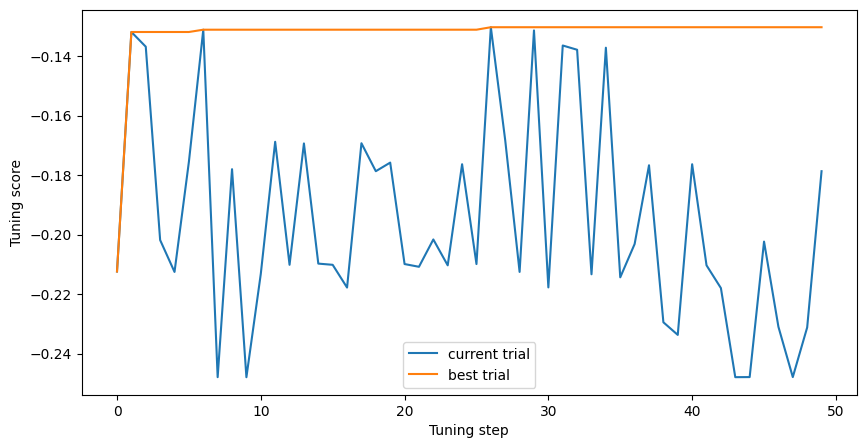

In [135]:
plt.figure(figsize=(10, 5))
plt.plot(tuning_logs["score"], label="current trial")
plt.plot(tuning_logs["score"].cummax(), label="best trial")
plt.xlabel("Tuning step")
plt.ylabel("Tuning score")
plt.legend()
plt.show()